In [1]:
import numpy as np
import tensorflow as tf
import tflearn
import h5py
from cnn_model import CNNModel
from PIL import Image

from skimage.morphology import ball
from skimage import measure, feature
from skimage.morphology import binary_dilation, binary_opening, binary_closing
from skimage.filters import roberts, sobel
from skimage.measure import label,regionprops, perimeter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline
from IPython.display import clear_output

In [2]:
FEATURE_DIR = '/notebooks/DSB3/data/stage1/stage1/'
INPUT_DATA_DIR = '/notebooks/DSB3/data/stage1_lungs_npy/'
OUTPUT_DATA_DIR = '/notebooks/ashish/seg_feats_2/'
model_file = 'nodule3-classifier.tfl'

In [3]:
tf.reset_default_graph()

IMG_SIZE = 50
input_shape = np.zeros((1, IMG_SIZE, IMG_SIZE, 1))

convnet = CNNModel()
fc_layer, network = convnet.define_network(input_shape, 'fc_feat')

model = tflearn.DNN(network, tensorboard_verbose=0)
model.load(model_file)

fc_model = tflearn.DNN(fc_layer, session = model.session)

In [4]:
def get_subimage(image, center, width):
    """
    Returns cropped image of requested dimensiona
    """
    z, y, x = center
    subImage = image[int(z), int(y-width/2):int(y+width/2), int(x-width/2):int(x+width/2)]
    return subImage.copy()

def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

def segment_nodules(segmented_ct_scan):
    segmented_ct_scan[segmented_ct_scan < -30] = 0
    segmented_ct_scan[segmented_ct_scan > 400] = 0
    
    selem = ball(2)
    binary = binary_closing(segmented_ct_scan, selem)
    
    return binary

def can_crop_image(image, center, width):
    z, y, x = center
    if int(z) >= image.shape[0] or int(y-width/2) < 0 or int(y+width/2) >= image.shape[1] or int(x-width/2) < 0 or int(x+width/2) >= image.shape[2]:
        return False
    else:
        return True

def contains_nodule(region, lungs):
    ## check if it classified as nodule based on model built using luna16 data
    center = region.coords.mean(axis=0)
    if can_crop_image(lungs, center, IMG_SIZE):
        img_chip = get_subimage(lungs, center, IMG_SIZE)
        img_chip_norm = normalizePlanes(img_chip)
    else:
        return False
    
    if img_chip_norm.shape[0] == IMG_SIZE and img_chip_norm.shape[1] == IMG_SIZE:
        prediction = model.predict(img_chip_norm.reshape((1,img_chip_norm.shape[0], img_chip_norm.shape[1], 1)))
        return (prediction[0][1] > 0.95)
    else:
        return False

In [5]:
def segmented_nodules_feats(segmented_ct_scan):
    binary = segment_nodules(segmented_ct_scan.copy())
    label_scan = label(binary)
    regions = regionprops(label_scan)

    areas = [r.area for r in regions]
    areas.sort()
    ############################
    
    totalArea = 0.
    avgArea = 0.
    maxArea = 0.
    avgEcc = 0.
    avgEquivlentDiameter = 0.
    stdEquivlentDiameter = 0.
    weightedX = 0.
    weightedY = 0.
    numNodes = 0.
    numNodesperSlice = 0.
    # crude hueristic to filter some bad segmentaitons
    # do not allow any nodes to be larger than 10% of the pixels to eliminate background regions
    maxAllowedArea = 0.10 * 512 * 512 
    eqDiameters = []
    final_regions = []

    for r in regions:
        max_x, max_y, max_z = 0, 0, 0
        min_x, min_y, min_z = 1000, 1000, 1000

        for c in r.coords:
            max_z = max(c[0], max_z)
            max_y = max(c[1], max_y)
            max_x = max(c[2], max_x)

            min_z = min(c[0], min_z)
            min_y = min(c[1], min_y)
            min_x = min(c[2], min_x)
            
        has_nodule = contains_nodule(r, segmented_ct_scan)
        if (min_z == max_z or min_y == max_y or min_x == max_x 
            or r.area > areas[-3] 
            or (max_z - min_z) < 1 
            or (max_z - min_z) > 50 
            or not has_nodule):
            for c in r.coords:
                segmented_ct_scan[c[0], c[1], c[2]] = 0
                binary[c[0], c[1], c[2]] = 0
        else:
            final_regions.append(r)
            
        #########
        if r.area > maxAllowedArea or not has_nodule:
            #print (r.area > maxAllowedArea, r.area, maxAllowedArea, has_nodule)
            continue
            
        totalArea += r.area
        #avgEcc += region.eccentricity
        avgEquivlentDiameter += r.equivalent_diameter
        eqDiameters.append(r.equivalent_diameter)
        
    numNodes = len(final_regions) + 1
    final_areas = [r.area for r in final_regions] + [0]
    maxArea = max(final_areas)
    avgArea = totalArea / numNodes
    #avgEcc = avgEcc / numNodes
    avgEquivlentDiameter = avgEquivlentDiameter / numNodes
    stdEquivlentDiameter = np.std(eqDiameters + [0])
    stdAreas = np.std(final_areas)
    
    return binary, segmented_ct_scan, final_regions, np.array([totalArea, avgArea, maxArea, avgEquivlentDiameter,\
                     stdEquivlentDiameter, numNodes, stdAreas])

In [6]:
def create_mosaic(image, nrows, ncols):
    """
    Tiles all the layers in nrows x ncols
    Args:
    ------
    image = 3d numpy array of M * N * number of filters dimensions
    nrows = integer representing number of images in a row
    ncol = integer representing number of images in a column
    returns formatted image
    """
    M = image.shape[1]
    N = image.shape[2]

    npad = ((0,0), (1,1), (1,1))
    image = np.pad(image, pad_width = npad, mode = 'constant', constant_values = 255)
    M += 2
    N += 2
    image = image.reshape(nrows, ncols, M, N)
    image = np.transpose(image, (0,2,1,3))
    image = image.reshape(M*nrows, N*ncols)
    return image

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.2, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [13]:
file = '/notebooks/DSB3/data/stage1_lungs_npy/0acbebb8d463b4b9ca88cf38431aac69.npy'  # cancer
#file = '/notebooks/DSB3/data/stage1_lungs_npy/008464bb8521d09a42985dd8add3d0d2.npy' # cancer
#file = '/notebooks/DSB3/data/stage1_lungs_npy/0015ceb851d7251b8f399e39779d1e7d.npy' # cancer
#file = '/notebooks/DSB3/data/stage1_lungs_npy/00edff4f51a893d80dae2d42a7f45ad1.npy' # cancer
#file = '/notebooks/DSB3/data/stage1_lungs_npy/0030a160d58723ff36d73f41b170ec21.npy' # no cancer
#file = '/notebooks/DSB3/data/stage1_lungs_npy/003f41c78e6acfa92430a057ac0b306e.npy' # no cancer
#file = '/notebooks/DSB3/data/stage1_lungs_npy/0121c2845f2b7df060945b072b2515d7.npy' # no cancer
#file = '/notebooks/DSB3/data/stage1_lungs_npy/8fe50e522e082c3752a0814da32f7e4c.npy'

lungs = np.load(file)
print (lungs.shape)

(203, 512, 512)


(<matplotlib.figure.Figure at 0x7f67b84435d0>,
 <matplotlib.image.AxesImage at 0x7f67b83ef250>)

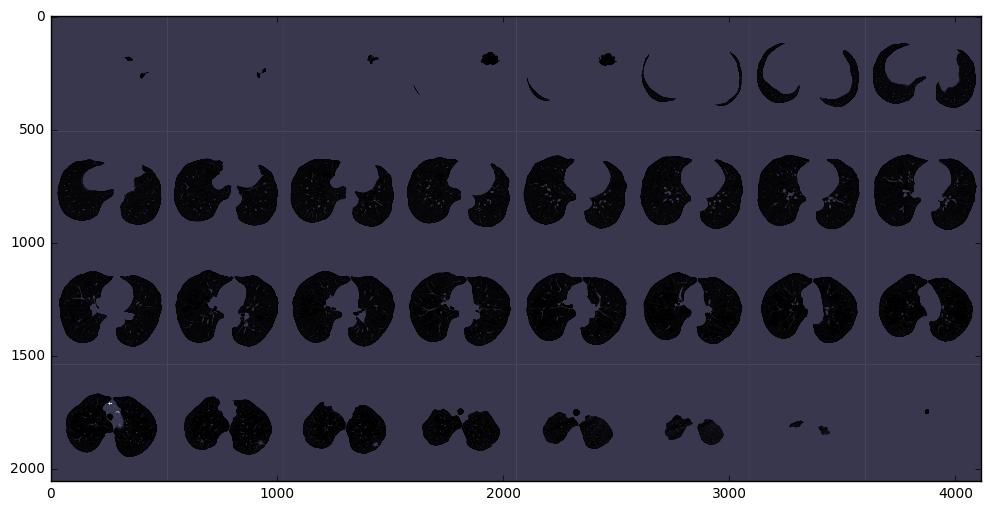

In [14]:
rows = 4
cols = 8
idx = np.linspace(0, len(lungs), rows*cols, endpoint=False, dtype=int)
mosaic = create_mosaic(lungs[idx,:,:], rows, cols)
plt.figure(figsize = (14, 6)), plt.imshow(mosaic, cmap = 'bone')

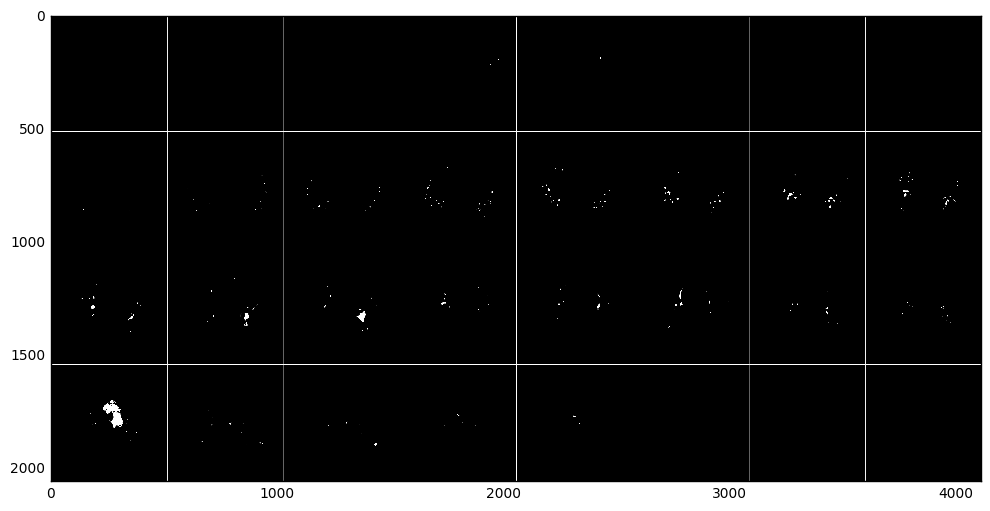

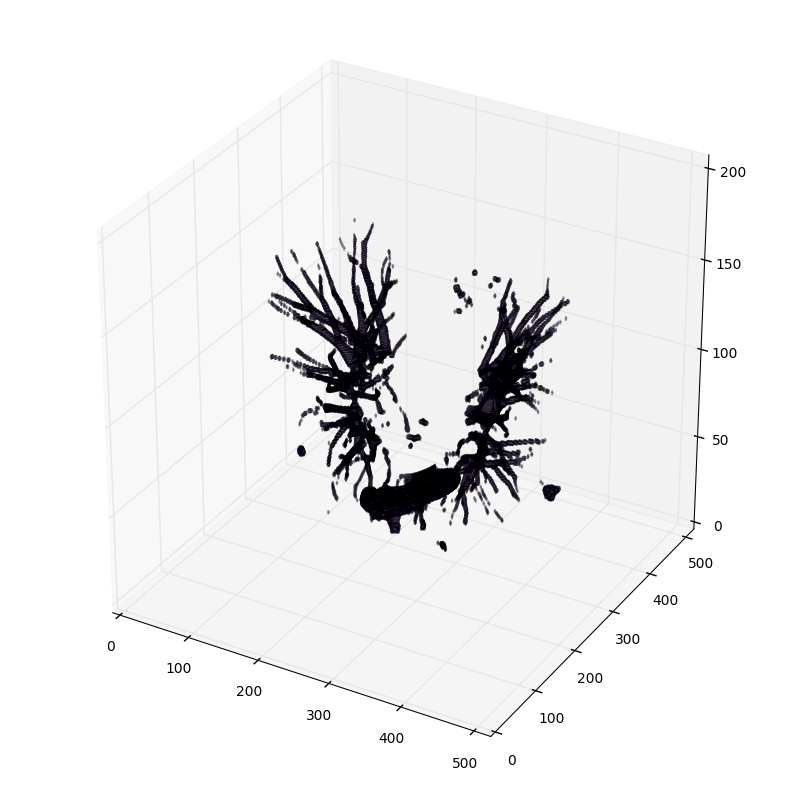

In [15]:
segmented_nodules = segment_nodules(lungs.copy())

mosaic = create_mosaic(segmented_nodules[idx,:,:], rows, cols)
plt.figure(figsize = (14, 6)), plt.imshow(mosaic, cmap = 'bone')

plot_3d(segmented_nodules, 0)

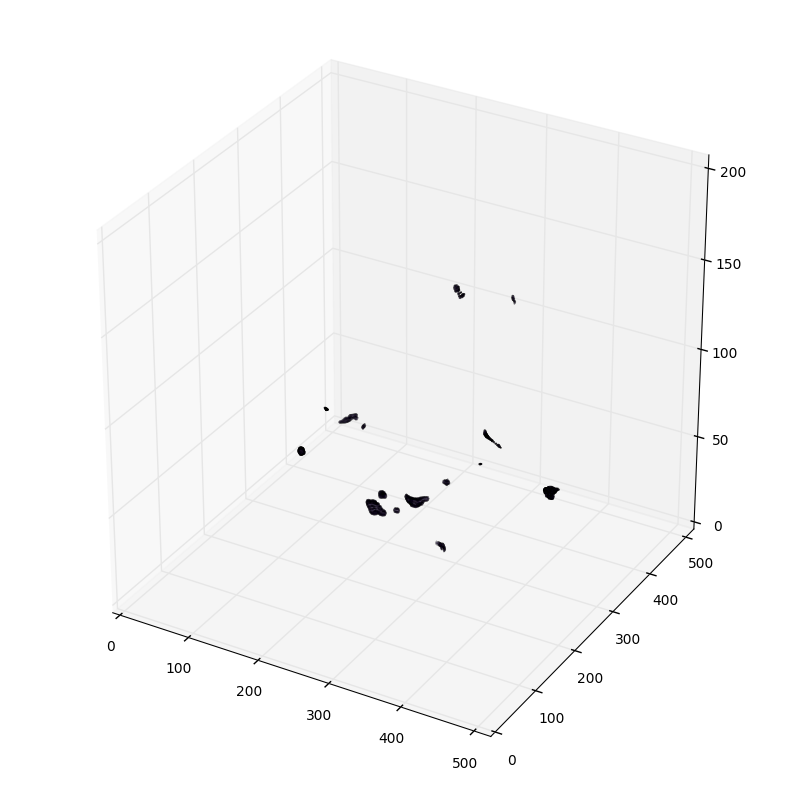

In [16]:
binary, seg_nod, final_regions, tmp = segmented_nodules_feats(lungs.copy())

plot_3d(seg_nod, 0)

('Index:', 0, 'Area:', 21, 'Center:', array([  20.9047619 ,  191.28571429,  435.80952381]))
('Index:', 1, 'Area:', 78, 'Center:', array([  22.88461538,  185.47435897,  365.51282051]))
('Index:', 2, 'Area:', 62, 'Center:', array([  99.19354839,  153.11290323,  201.48387097]))
('Index:', 3, 'Area:', 16, 'Center:', array([ 120.4375,  211.9375,  382.625 ]))
('Index:', 4, 'Area:', 111, 'Center:', array([ 131.52252252,  312.4954955 ,  339.46846847]))
('Index:', 5, 'Area:', 115, 'Center:', array([ 129.54782609,  162.87826087,  159.        ]))
('Index:', 6, 'Area:', 801, 'Center:', array([ 161.72908864,  348.1423221 ,  407.24094881]))


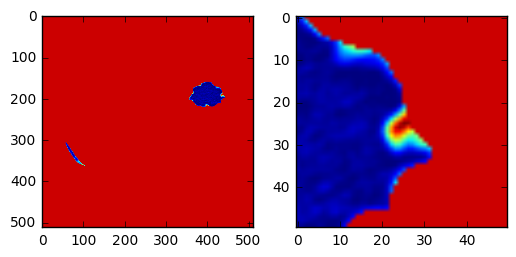

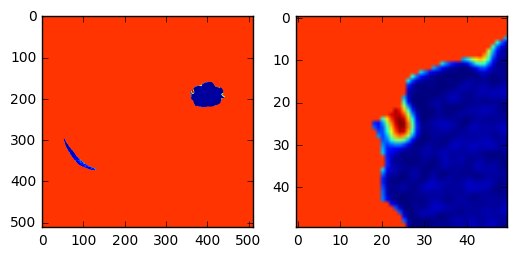

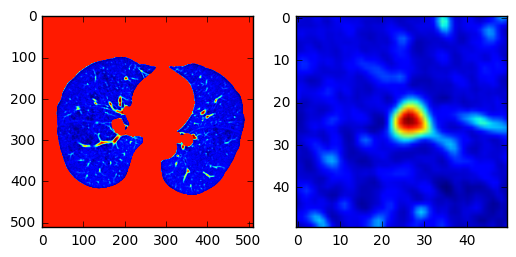

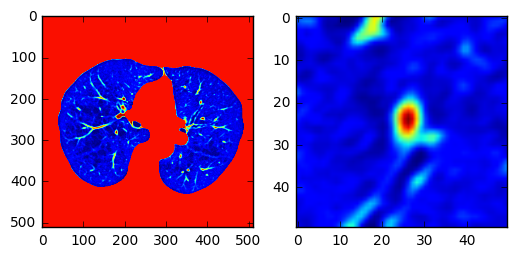

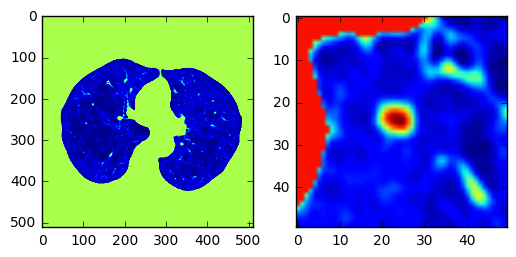

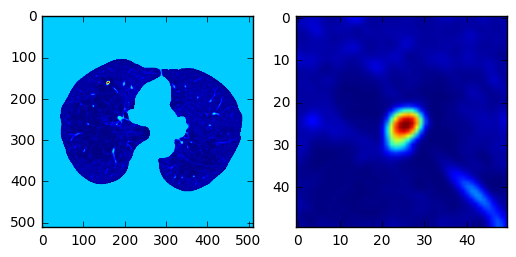

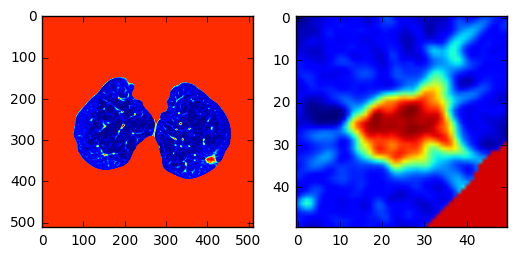

In [17]:
for idx, r in enumerate(final_regions):
    center = r.coords.mean(axis=0)
    print ("Index:", idx, "Area:", r.area, "Center:", center)
    plt.figure()
    plt.subplot(1,2,1), plt.imshow(lungs[int(center[0]),:,:])
    plt.subplot(1,2,2), plt.imshow(get_subimage(lungs, center, 50))